# Importing the Libraries

In [ ]:
# Importing for model related work
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision
from tqdm.autonotebook import tqdm

# Numpy matplotlib and pandas 
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Downloading the training set and testing set

In [ ]:
# For training set 
# Making the tensor and normalizing the data
train_set = torchvision.datasets.MNIST(
    root='./data',  # creating directory and giving the path
    train=True,     # True for training set
    download=True,  # True if data is not available in local storage
    transform=transforms.Compose([
        transforms.ToTensor(), # convert image to tensor
        transforms.Normalize((0.1307,), (0.3081,)) # Normalize image with mean and standard deviation
    ])
)

# For testing set
# Making the tensor and normalizing the data
test_set = torchvision.datasets.MNIST(
    root='./data',    #  giving the directory path
    train=False,      # False for testing set
    transform=transforms.Compose([
        transforms.ToTensor(),  # convert image to tensor
        transforms.Normalize((0.1307,), (0.3081,))   # Normalize image with mean and standard deviation
    ])
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Data Generation and Combining two inputs:

Taking downloaded MNIST data set and generating a tensor containing 0 to 9 random numbers. Accessing image with label from data. Accessing generated number of same image to equalized the data.
Now, return image, label of the image, random number and sum of label & random number.  

### This is how our dataset should look like
|MNSIT IMAGE LABEL | RANDOM NUMBER (0 to 9) | SUM of NUMBER | 
| :--------:     | :-----------------------: | :---------:   |
| 7 | 2 | 9 |
| 1 | 5 | 6 |
| 5 | 6 | 11 | 
| 4 | 7 | 11 |
| 3 | 1 | 4 |

In [ ]:
class Numbers(Dataset):
  def __init__(self, data):
    self.data = data  # Giving tensor of downloaded data
    self.numbers = torch.randint(0, 10,(len(self.data),1), dtype=torch.float) # Generating a tensor containing random number (from 0-10) of size of data

  def __getitem__(self, index):
    r = self.data[index]    # Accessing item using index
    image, label = r
    num = self.numbers[index] # Accessing generated number of same image
    sum = num + label  # Initializing the sum 
    return image, num, label, sum   # Returning the image, random number, label and sum of label and random number

  def __len__(self):
    return len(self.data) # Getting number of attribute in dataset

# Train Loader and Test Loader

In [ ]:
torch.manual_seed(1) 
batch_size = 256 # Batch size with 256
use_cuda = torch.cuda.is_available() # GPU enabled
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = DataLoader(
    Numbers(train_set),  # Putting the training set in Numbers class and getting the image label sum and random number
    batch_size=batch_size, 
    shuffle=True, # shuffle the dataset
    **kwargs
)

test_loader = DataLoader(
    Numbers(test_set), # Putting the testing set in Numbers class and getting the image label sum and random number 
    batch_size=batch_size,
    shuffle=True, # Shuffle the dataset
    **kwargs
)

In [ ]:
next(iter(train_loader))[1].shape    # Checking shape of input random number

torch.Size([256, 1])

# Data Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


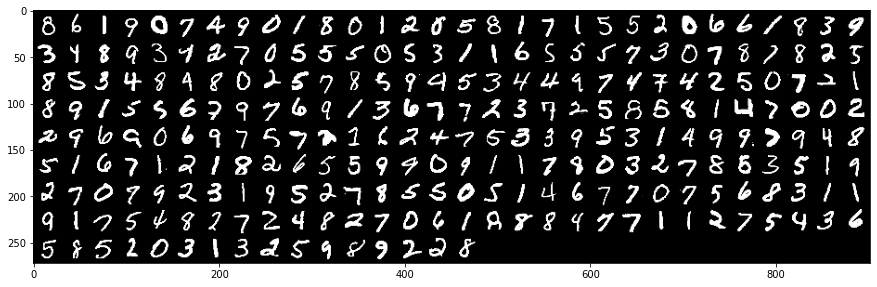

In [ ]:
batch = next(iter(train_loader))   # Accesing batch
images,num ,labels, sum = batch

grid = torchvision.utils.make_grid(images, nrow=30)    # Creating grid of images
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(grid, (1,2,0)))

In [ ]:
print('labels:\n', labels[:10])    # Labels of first 10 images
print('Random Generated Numbers:\n', num[:10].reshape((1,10)))   # Random number generated for corresponding image
print('sum:\n',sum[:10].reshape((1,10)))    # Sumation of labels and random number

labels:
 tensor([8, 6, 1, 9, 0, 7, 4, 9, 0, 1])
Random Generated Numbers:
 tensor([[2., 0., 7., 1., 8., 9., 3., 9., 5., 4.]])
sum:
 tensor([[10.,  6.,  8., 10.,  8., 16.,  7., 18.,  5.,  5.]])


#Defining Neural Networks
 Making the Neural Network which takes image and random number as input and gives label and label + random_number as output.

 ### Why we have choose ReLU as an activation function

ReLU stands for Rectified Linear Unit. The main advantage of using the ReLU function over other activation functions is that it does not activate all the neurons at the same time.


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # For processing the Image
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)    # input: 28x28x1, output: 28x28x32, RF: 3x3
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)   # input: 28x28x32, output: 28x28x64, RF: 5x5
        # The max pooling layer
        self.pool1 = nn.MaxPool2d(2, 2)   # input: 14x14x64, output: 14x14x64, RF: 10x10
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # input: 14x14x64, output: 14x14x128, RF: 12x12
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1) # input: 14x14x128, output: 14x14x256, RF: 14x14
        # The max pooling layer
        self.pool2 = nn.MaxPool2d(2, 2)   # input: 7x7x256, output: 7x7x256, RF: 28x28
        self.conv5 = nn.Conv2d(256, 512, 3)    # input: 7x7x256, output: 5x5x512, RF: 30x30
        self.conv6 = nn.Conv2d(512, 1024, 3)   # input: 5x5x512, output: 3x3x1024, RF: 32x32
        self.conv7 = nn.Conv2d(1024, 10, 3)    # input: 3x3x1024, output: 1x1x10, RF: 34x34
        

        # For processing the random number
        # 5 linear layers for adding the numbers
        # We use danse layer to proccess numerical number
        self.dense1 = nn.Linear(1, 8)   # One input neuron connected with 8 output neurons
        self.dense2 = nn.Linear(8, 32)  # 8 input neurons connected with 32 output neurons
        self.dense3 = nn.Linear(32 + 10, 128)   # 32 neuron comes form dense1 & dense2 and 10 neurons comes from convolutions connected with 128 output neurons
        self.dense4 = nn.Linear(128, 256)    # 128 neurons connected with 256 neurons
        self.dense5 = nn.Linear(256, 1)    # 256 neurons connected with 1 final neuron 

    def forward(self, x, num):
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))   # Convolving input image twice and then applying relu 
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))   # as an activation function and doing max pooling
        x = F.relu(self.conv6(F.relu(self.conv5(x))))
        x = self.conv7(x)
        x = x.view(-1, 10)
        out_1 = F.log_softmax(x)   # Computing probabilitic representation of each class

        num = F.relu(self.dense1(num))  # ReLU as an activation function on dense1
        num = F.relu(self.dense2(num))  # ReLU as an activation function on dense2

        out_2 = torch.cat((x, num), dim=1)    # Concatinating num and x(network of MNIST dataset)
        out_2 = F.relu(self.dense3(out_2))
        out_2 = F.relu(self.dense4(out_2))
        out_2 = self.dense5(out_2)
        
        return out_1, out_2

# Printing the model 

In [ ]:
# Loading network
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(1024, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dense1): Linear(in_features=1, out_features=8, bias=True)
  (dense2): Linear(in_features=8, out_features=32, bias=True)
  (dense3): Linear(in_features=42, out_features=128, bias=True)
  (dense4): Linear(in_features=128, out_features=256, bias=True)
  (dense5): Linear(in_features=256, out_features=1, bias=True)
)


# Loss functions and optimization

In [ ]:
# For training set
def train(model, device, train_loader, optimizer, epoch):
    model.train()   # training the model
    pbar = tqdm(train_loader)    # For progressbar visualization

    # Calling batch one by one
    for batch_idx, (data, num, label, sum) in enumerate(pbar):

        data, num, label, sum = data.to(device), num.to(device), label.to(device), sum.to(device)
        optimizer.zero_grad()    # set the gradients to zero before starting to do backpropragation

        pred_label, pred_sum = model(data, num)  # Predicted label and Predicted sum

        loss1 = F.nll_loss(pred_label, label)   # Calculating loss for label of image
        loss2 = F.mse_loss(pred_sum, sum)   # Calculating loss for sum of random number and label
        loss = loss1 + loss2  # calculating the final loss

        loss.backward() # Back propogation
        optimizer.step()   #  makes the optimizer iterate over all parameters (tensors)

        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

# For testing set
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, num, label, sum in test_loader:
            data, num, label, sum = data.to(device), num.to(device), label.to(device), sum.to(device)
            pred_label, pred_sum = model(data, num) # Predicted output (label and sum of label and random number)

            # Calculating loss for label and random number of test
            test_loss += F.nll_loss(pred_label, label, reduction='sum').item() + F.mse_loss(pred_sum, sum, reduction='sum').item() # sum up batch loss
            # Predicted output
            pred = pred_label.argmax(dim=1, keepdim=True)  # returns maximum value of all elements in the input tensor
            correct += pred.eq(label.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)     # optimization technique for gradient descent

# Defining the epoch and iterating through epochs
for epoch in range(1, 15):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.




Test set: Average loss: 1.2640, Accuracy: 9337/10000 (93.37%)





Test set: Average loss: 0.5317, Accuracy: 9801/10000 (98.01%)





Test set: Average loss: 0.3410, Accuracy: 9861/10000 (98.61%)





Test set: Average loss: 0.2714, Accuracy: 9882/10000 (98.82%)





Test set: Average loss: 0.1765, Accuracy: 9901/10000 (99.01%)





Test set: Average loss: 0.2355, Accuracy: 9901/10000 (99.01%)





Test set: Average loss: 0.1970, Accuracy: 9927/10000 (99.27%)





Test set: Average loss: 0.1528, Accuracy: 9921/10000 (99.21%)





Test set: Average loss: 0.1606, Accuracy: 9907/10000 (99.07%)





Test set: Average loss: 0.1566, Accuracy: 9935/10000 (99.35%)





Test set: Average loss: 0.1755, Accuracy: 9929/10000 (99.29%)





Test set: Average loss: 0.1209, Accuracy: 9944/10000 (99.44%)





Test set: Average loss: 0.1273, Accuracy: 9937/10000 (99.37%)





Test set: Average loss: 0.1508, Accuracy: 9913/10000 (99.13%)



# Evaluating the model
We split our dataset into train and test.
For training set
  1. train the model 
  2. Set the gradient to zero before staring to do back propogation.
  3. Get predicted label of image and sum
  4. Calculating loss for label of image and sum (label + random number) using MSE loss function.
  5. Calculate the final loss of train dataset.

for testing set
  1. Validate model with using zero gradient to turn off gradients computation.
  2. Calculating loss for label and random number of test dataset by using nll and MSE loss function.
  3. Calculate the final loss of test dataset.

### Loss Functions which are used:
#### Negative Log-Likelihood Loss(nn.NLLLoss)
The negative log likelihood loss is mostly used in classification problems, here Likelihood refers to the chances of some calculated parameters producing some known data.

#### Mean Square Error (MSE)
MSE is the most commonly used regression loss function. MSE is the sum of squared distances between our target variable and predicted values.

In general we use nll loss function for classification problem and MSE for regression problem. In our case we use MNIST dataset which come into classification and random number dataset comes into regression.



In [ ]:
im , lab = next(iter(test_set))  # Accessing image and label from test dataset
im = im.to(device)   # Sending image to GPU
num = torch.tensor([5], dtype=torch.float).unsqueeze(0).to(device)   # creating batch
pred =  model(im.unsqueeze(0), num)   # Adding 1 dimension w.r.t. row (creating a batch)
print("predtion", pred[0].argmax(), "\nsum of pred and number", pred[1], f'\noriginal  label: {lab}')

predtion tensor(7, device='cuda:0') 
sum of pred and number tensor([[11.9574]], device='cuda:0', grad_fn=<AddmmBackward>) 
original  label: 7


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


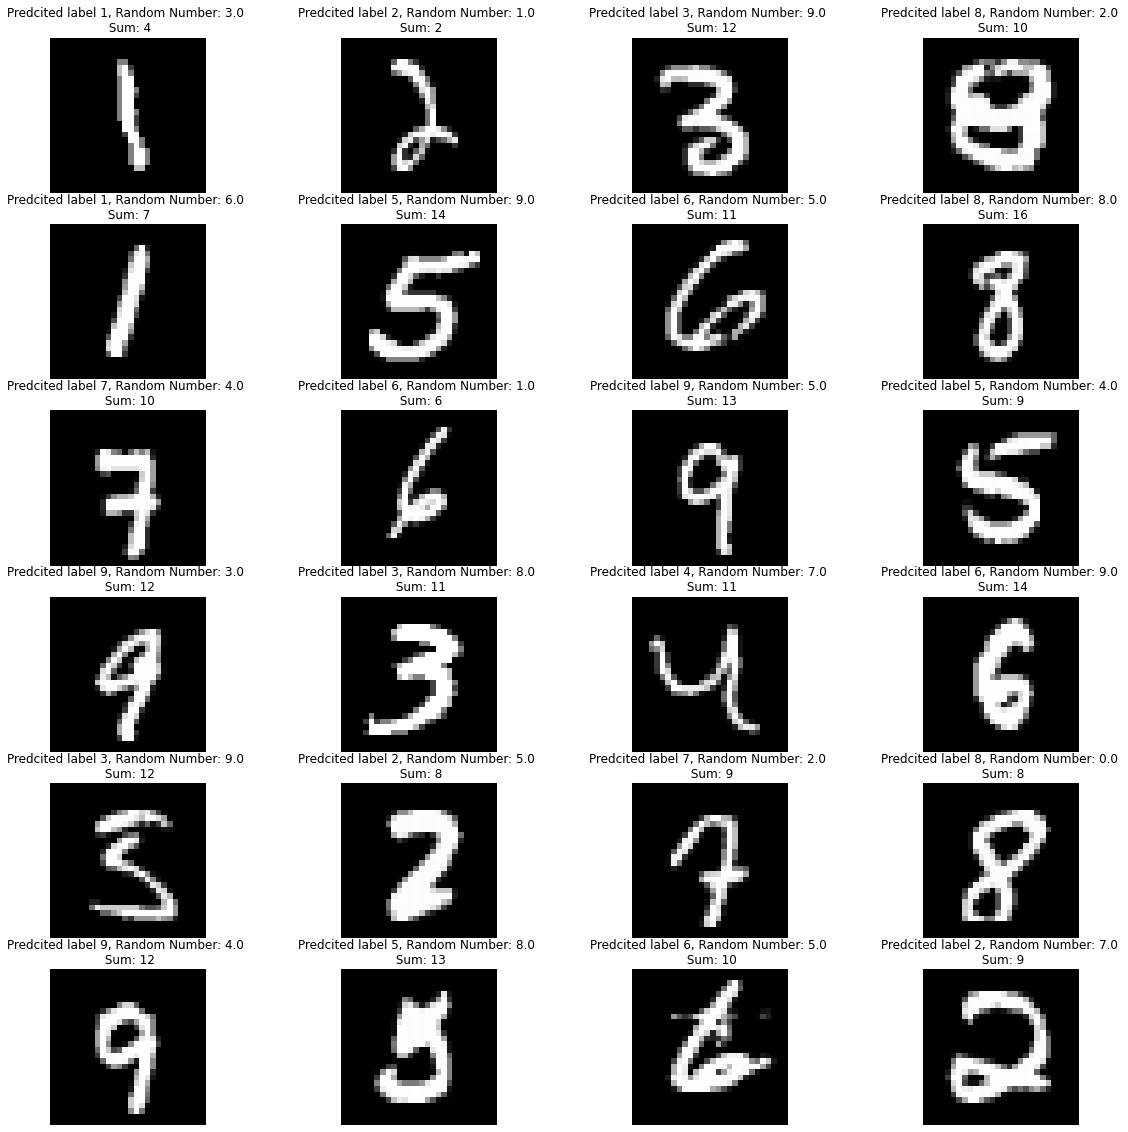

In [ ]:
cols, rows = 4,6
figure = plt.figure(figsize=(20, 20))
for i in range(1, cols * rows + 1):
    k = np.random.randint(0, len(test_set))
    num = np.random.randint(0, 10)
    num = torch.tensor([num], dtype=torch.float).unsqueeze(0).to(device)

    img, label = test_set[k]
    img = img.unsqueeze(0)
    pred_lab, pred_sum =  model(img.to(device), num.to(device))

    figure.add_subplot(rows, cols, i)
    plt.title(f"Predcited label {pred_lab.argmax().item()}, Random Number: {num.item()} \n Sum: {int(pred_sum.item())}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

plt.show()